In [1]:
import os
import getpass
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from qdrant_client import QdrantClient
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain_community.document_compressors import JinaRerank
from langchain.retrievers import ContextualCompressionRetriever
from langchain.vectorstores import Qdrant
from langchain.embeddings import FastEmbedEmbeddings
from langchain.chains import RetrievalQA
from typing import *

from src.base.llm import SingletonChatLLM

/Users/genson1808/workspace/ai/rag_advanced/RAG-chat-with-documents/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %pip install langgraph
# %pip install jina

In [3]:
# Load environment variables
load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")
os.environ["JINA_API_KEY"] = os.getenv("JINA_API_KEY")


In [4]:
from langgraph.checkpoint.memory import MemorySaver

In [5]:
# Hàm trích xuất loại tin nhắn và nội dung
def extract_message_types_and_content(messages: List):
    for message in messages:
        message_type = type(message).__name__
        content = message.content
        print(f"{message_type}: {content}")

In [6]:
from langgraph.graph import MessagesState
from typing import Literal
from typing_extensions import TypedDict

# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    messages: list  # Store the conversation history
    next: str


chat_model = SingletonChatLLM(llm_name='CHAT_GROQ').get_llm()

# Định nghĩa các agent cần thiết
members = ["lt4670_assistant", "lv4830_assistant", "NDI_checker_assistant", "customer_care"]

options = members + ["FINISH"]

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]

system_prompt = (
    # "You are a supervisor tasked with managing a conversation between the"
    # f" following workers: {members}. Given the following user request,"
    # " respond with the worker to act next. Each worker will perform a"
    # " task and respond with their results and status. When finished,"
    # " respond with FINISH."
    "You are a routing supervisor. Based on the user's current input and conversation history, "
    "route the input to one of the following agents:\n"
    "- 'lt4670_assistant': For questions about the LT4670 monitor.\n"
    "- 'lv4830_assistant': For questions about the LV4830 monitor.\n"
    "- 'NDI_checker_assistant': For questions about the NDI Checker or NDI protocol.\n"
    "- 'customer_care': For general inquiries or unrelated questions.\n\n"
    "If the input is ambiguous, use history to determine the best route. If still unsure, route to 'customer_care'."

    # "You are a supervisor tasked with managing a conversation between the"
    # f" following workers: {members}. Based on the user request:"
    # "\n- If the request contains 'lt4670', route to 'product1_assistant'."
    # "\n- If the request contains 'bc289', route to 'product2_assistant'."
    # "\n- Otherwise, route to 'customer_care'."
    # "\nEach worker will perform a task and respond with their results and status."
    # " When finished, respond with 'FINISH'."
)

# Define the supervisor node and agent states
def supervisor_node(state: AgentState) -> AgentState:
    # print(state["messages"])
    extract_message_types_and_content(state["messages"])
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = chat_model.with_structured_output(Router).invoke(messages)
    next_ = response["next"]
    if next_ == "FINISH":
        next_ = END
    return {"next": next_}




In [7]:
custom_prompt_template = """You are a helpful assistant, You must use japanese to answer the question, conversing with a user about the subjects contained in a set of documents.
Use the information from the DOCUMENTS section to provide accurate answers. If unsure or if the answer
isn't found in the DOCUMENTS section, simply state that you don't know the answer.

Documents:
{context}

Question:
{question}

Answer:
"""

def set_custom_prompt():
    """
    Prompt template for QA retrieval for each vectorstore
    """
    prompt = PromptTemplate(template=custom_prompt_template,
                            input_variables=['context', 'question'])
    return prompt

In [8]:
client = QdrantClient(api_key=QDRANT_API_KEY, url=QDRANT_URL,)

from langchain_community.document_compressors import JinaRerank
from langchain.retrievers import ContextualCompressionRetriever

os.environ["JINA_API_KEY"] = os.getenv("JINA_API_KEY")
def retrieval_qa_chain(llm, prompt, vectorstore):
    retriever = vectorstore.as_retriever(search_kwargs={'k': 2})
    compressor = JinaRerank()
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor, base_retriever=retriever
    )
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=compression_retriever,
        return_source_documents=True,
        chain_type_kwargs={'prompt': prompt}
    )
    return qa_chain


def qa_bot():
    embeddings = FastEmbedEmbeddings()
    vectorstore = Qdrant(client=client, embeddings=embeddings, collection_name="rag2")
    llm = chat_model
    qa_prompt=set_custom_prompt()
    qa = retrieval_qa_chain(llm, qa_prompt, vectorstore)
    return qa

qa = qa_bot()

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 76818.75it/s]
/var/folders/jz/yzdjtm5x47l3dgzz8v9132mh0000gn/T/ipykernel_3172/2787988734.py:25: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  vectorstore = Qdrant(client=client, embeddings=embeddings, collection_name="rag2")


In [9]:
# Define the QA agent nodes
def lt4670_agent_node(state: AgentState) -> AgentState:
    user_input = state["messages"][-1].content

    response = f"messages: {user_input} - agent: LT4670_agent"
    return {
        "messages": [{"role": "assistant","content": response, "name": "LT4670"}]
    }

In [10]:
def lv4830_agent_node(state: AgentState) -> AgentState:
    user_input = state["messages"][-1].content

    response = f"messages: {user_input} - agent: LV4830_agent"
    return {
        "messages": [{"role": "assistant","content": response, "name": "LV4830"}]
    }

In [11]:
def ndi_checker_agent_node(state: AgentState) -> AgentState:
    user_input = state["messages"][-1].content

    response = f"messages: {user_input} - agent: ndi_checker_agent"
    return {
        "messages": [{"role": "assistant","content": response, "name": "ndi_checker"}]
    }

In [12]:
def customer_care_agent_node(state: AgentState) -> AgentState:
    user_input = state["messages"][-1].content

    response = f"messages: {user_input} - agent: customer_care_agent"
    return {
        "messages": [{"role": "assistant","content": response, "name": "customer_care"}]
    }

In [13]:
# Setup the agent state graph and add conditional edges
# members = ["lt4670_assistant", "lv4830_assistant", "NDI_checker_assistant", "customer_care"]
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("lt4670_assistant", lt4670_agent_node)
builder.add_node("lv4830_assistant", lv4830_agent_node)
builder.add_node("NDI_checker_assistant", ndi_checker_agent_node)
builder.add_node("customer_care", customer_care_agent_node)

builder.add_edge("lt4670_assistant", "__end__")
builder.add_edge("lv4830_assistant", "__end__")
builder.add_edge("NDI_checker_assistant", "__end__")
builder.add_edge("customer_care", "__end__")

# for member in members:
#     builder.add_edge(member, "supervisor")

builder.add_conditional_edges("supervisor", lambda state: state["next"])
checkpointer = MemorySaver()
# Compile the graph and execute it
graph = builder.compile(checkpointer=checkpointer)

config = {'configurable': {'thread_id': '1'}}

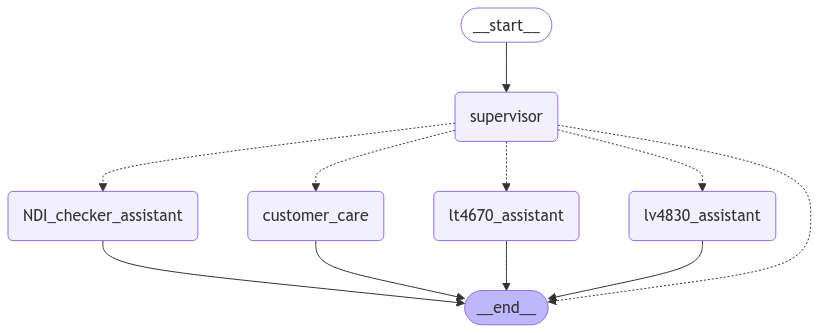

In [14]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [15]:

response = graph.invoke(
    {"messages":
     [HumanMessage(content="how to configure display on lt4670")]}, config)
print(response["messages"][-1].content)
response = graph.invoke(
    {"messages":
     [HumanMessage(content="how to configure hdr")]}, config)
print(response["messages"][-1].content)

HumanMessage: how to configure display on lt4670
messages: how to configure display on lt4670 - agent: LT4670_agent
HumanMessage: how to configure display on lt4670
AIMessage: messages: how to configure display on lt4670 - agent: LT4670_agent
HumanMessage: how to configure hdr
messages: how to configure hdr - agent: LT4670_agent


In [16]:
response = graph.invoke(
    {"messages":
     [HumanMessage(content="how to configure hdr")]}, config)
print("-------------answer-------------")
print(response["messages"][-1].content)

response = graph.invoke(
    {"messages":
     [HumanMessage(content="how to configure volume")]}, config)
print("-------------answer-------------")
print(response["messages"][-1].content)

HumanMessage: how to configure display on lt4670
AIMessage: messages: how to configure display on lt4670 - agent: LT4670_agent
HumanMessage: how to configure hdr
AIMessage: messages: how to configure hdr - agent: LT4670_agent
HumanMessage: how to configure hdr
-------------answer-------------
messages: how to configure hdr - agent: LT4670_agent
HumanMessage: how to configure display on lt4670
AIMessage: messages: how to configure display on lt4670 - agent: LT4670_agent
HumanMessage: how to configure hdr
AIMessage: messages: how to configure hdr - agent: LT4670_agent
HumanMessage: how to configure hdr
AIMessage: messages: how to configure hdr - agent: LT4670_agent
HumanMessage: how to configure volume
-------------answer-------------
messages: how to configure volume - agent: LT4670_agent


In [17]:
response = graph.invoke(
    {"messages":
     [HumanMessage(content="how to configure hdr")]}, config)
print("-------------answer-------------")
print(response["messages"][-1].content)

HumanMessage: how to configure display on lt4670
AIMessage: messages: how to configure display on lt4670 - agent: LT4670_agent
HumanMessage: how to configure hdr
AIMessage: messages: how to configure hdr - agent: LT4670_agent
HumanMessage: how to configure hdr
AIMessage: messages: how to configure hdr - agent: LT4670_agent
HumanMessage: how to configure volume
AIMessage: messages: how to configure volume - agent: LT4670_agent
HumanMessage: how to configure hdr
-------------answer-------------
messages: how to configure hdr - agent: LT4670_agent


In [18]:
response = graph.invoke(
    {"messages":
     [HumanMessage(content="contract of company")]}, config)
print("-------------answer-------------")
print(response["messages"][-1].content)

HumanMessage: how to configure display on lt4670
AIMessage: messages: how to configure display on lt4670 - agent: LT4670_agent
HumanMessage: how to configure hdr
AIMessage: messages: how to configure hdr - agent: LT4670_agent
HumanMessage: how to configure hdr
AIMessage: messages: how to configure hdr - agent: LT4670_agent
HumanMessage: how to configure volume
AIMessage: messages: how to configure volume - agent: LT4670_agent
HumanMessage: how to configure hdr
AIMessage: messages: how to configure hdr - agent: LT4670_agent
HumanMessage: contract of company
-------------answer-------------
messages: contract of company - agent: customer_care_agent


In [19]:
response = graph.invoke(
    {"messages":
     [HumanMessage(content="What is NDI checker")]}, config)
print("-------------answer-------------")
print(response["messages"][-1].content)

HumanMessage: how to configure display on lt4670
AIMessage: messages: how to configure display on lt4670 - agent: LT4670_agent
HumanMessage: how to configure hdr
AIMessage: messages: how to configure hdr - agent: LT4670_agent
HumanMessage: how to configure hdr
AIMessage: messages: how to configure hdr - agent: LT4670_agent
HumanMessage: how to configure volume
AIMessage: messages: how to configure volume - agent: LT4670_agent
HumanMessage: how to configure hdr
AIMessage: messages: how to configure hdr - agent: LT4670_agent
HumanMessage: contract of company
AIMessage: messages: contract of company - agent: customer_care_agent
HumanMessage: What is NDI checker
-------------answer-------------
messages: What is NDI checker - agent: ndi_checker_agent


In [20]:
%pip install langserve

Note: you may need to restart the kernel to use updated packages.


In [21]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [22]:
%pip install  sse_starlette

Note: you may need to restart the kernel to use updated packages.


In [24]:
from fastapi import FastAPI
from typing_extensions import TypedDict

from langchain_core.runnables import RunnableLambda
from langserve import add_routes

def inp(question: str) -> dict:
    return {"question": question}


def out(state: dict):
    result = state[1]["generate"]["generation"]  # 0: retrieve, 1: generate
    return result

final_chain = RunnableLambda(inp) | graph | RunnableLambda(out)

fastapi_app = FastAPI(  # Initialize FastAPI app
    title="PDF Q&A bot",
    version="0.1",
    description="PDF Q&A Chatbot Server with Langgraph + Langserve",
)
add_routes(fastapi_app, final_chain)



In [26]:
import uvicorn
import asyncio

asyncio.run(uvicorn.run(fastapi_app, host="0.0.0.0", port=5000))
# uvicorn.run(fastapi_app, host="0.0.0.0", port=5000)

/Users/genson1808/workspace/ai/rag_advanced/RAG-chat-with-documents/.venv/lib/python3.12/site-packages/pygments/regexopt.py:77: RuntimeWarning: coroutine 'Server.serve' was never awaited
  '|'.join(regex_opt_inner(list(group[1]), '')


RuntimeError: asyncio.run() cannot be called from a running event loop

In [32]:
import requests
import json

inputs = {"input": "한국의 대통령은 누구야?", "confi"}
response = requests.post("http://localhost:8000/invoke", json=inputs)
result = response.json()
print(result["output"])

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [33]:
%pip install langgraph-sdk

Note: you may need to restart the kernel to use updated packages.


In [35]:
from langgraph_sdk import get_client

client = get_client(url="http://localhost:60859")

async for chunk in client.runs.stream(
    None,  # Threadless run
    "agent", # Name of assistant. Defined in langgraph.json.
    input={
        "messages": [{
            "role": "human",
            "content": "What is LangGraph?",
        }],
    },
    stream_mode="updates",
):
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1efaa74e-75de-6bff-bb7e-e41dccceed76', 'attempt': 1}



Receiving new event of type: updates...
{'supervisor': {'next': 'customer_care'}}



Receiving new event of type: updates...
{'customer_care': {'messages': 'messages: What is LangGraph? - agent: customer_care_agent'}}





In [ ]:
from langgraph_sdk import get_client

client = get_client(url="http://localhost:63408")
# Using the graph deployed with the name "agent"
graph_name = "agent"
res = client.assistants.get(graph_name)
res